In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [16]:
IMAGE_SIZE = 28
BATCH_SIZE = 32
CHANNELS =1
EPOCHS=5

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "ROI_data",
    shuffle = True,
    batch_size =BATCH_SIZE
)

Found 2830 files belonging to 2 classes.


In [18]:
class_names =dataset.class_names
class_names

['Benign', 'Cancer']

In [19]:

for image_batch , label_batch in dataset.take(1):
       print(image_batch[0].numpy().astype(int).shape)
       
      

(256, 256, 3)


In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam
import tensorflow as tf



target_size = (224, 224)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, target_size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, target_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, target_size), y))






In [23]:
for image_batch , label_batch in train_ds.take(1):
       print(image_batch[0].numpy().astype(int).shape)

(224, 224, 3)


In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])



In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',        
    patience=5,                  
    min_delta=1e-7,            
    restore_best_weights=True,  
)

# Define a ReduceLROnPlateau callback
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.2,          
    patience=2,           
    min_delta=1e-7,       
    cooldown=0,           
    verbose=1           
) 



In [26]:
pretrained_model = ResNet152(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
for layer in pretrained_model.layers:
    layer.trainable = False
    
resnet_model = Sequential()    
resnet_model.add(pretrained_model)




In [27]:
inputs = tf.keras.Input(shape=(224, 224, 3))  
x = pretrained_model(inputs, training=False) 

x = layers.Dense(512, activation='relu')(x)  
x = layers.Dropout(0.5)(x)  
x = layers.Dense(512, activation='relu')(x)  
x = layers.Dropout(0.5)(x)  
outputs = layers.Dense(1, activation='sigmoid')(x) 

resnet_model = models.Model(inputs, outputs)



In [28]:

custom_optimizer = Adam(learning_rate=0.001) 
resnet_model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])



In [29]:
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 1000)              60419944  
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513   

In [30]:

history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, plateau]
)



Epoch 1/5


12/71 [====>.........................] - ETA: 3:25 - loss: 0.6921 - accuracy: 0.5164

KeyboardInterrupt: 

In [17]:
scores = resnet_model.evaluate(test_ds)

10/10 [==============================] - 45s 4s/step - loss: 0.6443 - accuracy: 0.6281


In [19]:
history.history['accuracy']

[0.5443655848503113,
 0.5905057787895203,
 0.6020408272743225,
 0.6144631505012512,
 0.6100265979766846]

first image to predict
first image's actual label: Cancer
1/1 [==============================] - 9s 9s/step
12
predicted label: Benign


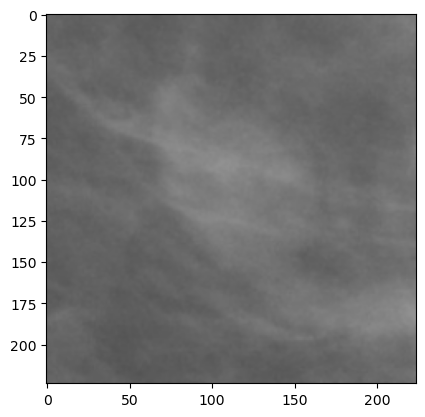

In [22]:
import numpy as np 
for images_batch, labels_batch in test_ds.take(1):
   first_image=images_batch[0].numpy().astype('uint8')
   first_label=labels_batch[0].numpy()
   print("first image to predict")
   plt.imshow(first_image)
   print("first image's actual label:", class_names[first_label])
   batch_prediction = resnet_model.predict(images_batch)
   print(np.argmax(batch_prediction))
   print ("predicted label:",class_names[np.argmax(batch_prediction[0])])
   

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Assuming your mammography images have a shape of (height, width, channels)
input_shape = (224, 224, 3)  # Adjust according to your image size

# Load ResNet152 model without the top (classification) layer
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Adjust num_classes according to your problem

# Combine base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



# Assuming you have a directory structure for your dataset
 = train_datagen.flow_from_directory(
    train_ds,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



# Model checkpointing
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, lr_callback]
)
